In [1]:
import math, itertools, copy
import numpy as np
import matplotlib.pyplot as plt

from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.models import ClusterGraph, MarkovModel, BayesianModel
from pgmpy.inference.ExactInference import BeliefPropagation

from pgm_utils import *
from pgm_algorithms import MeanFieldInference, LoopyBeliefPropagation

%matplotlib inline

In [2]:
def experiment_2():
    # Set up factors
    np.random.seed(seed=1)

    factor_A = TabularCPD(variable="A", variable_card=3,
                          values=[[0.01, 0.90, 0.09]])
    factor_B = TabularCPD(variable="B", variable_card=4,
                          values=[[0.25, 0.25, 0.25, 0.25]])
    factor_C = TabularCPD(variable="C", variable_card=2,
                          values=[[0.75, 0.25]])
    factor_D = TabularCPD(variable="D", variable_card=2,
                          values=[[0.25, 0.75]])
    factor_E = TabularCPD(variable="E", variable_card=3,
                          values=[[0.1, 0.80, 0.25, 0.01, 0.25, 0.6, 0.90, 0.2, 0.50, 0.50, 0.01, 0.01],
                                  [0.2, 0.05, 0.25, 0.80, 0.25, 0.2, 0.05, 0.4, 0.45, 0.05, 0.80, 0.90],
                                  [0.7, 0.15, 0.50, 0.19, 0.50, 0.2, 0.05, 0.4, 0.05, 0.45, 0.19, 0.09]],
                          evidence=["A", "B"],
                          evidence_card=[3,4])
    factor_F = TabularCPD(variable="F", variable_card=2,
                          values=[[0.45, 0.55, 0.2, 0.90],
                                  [0.55, 0.45, 0.8, 0.10]],
                          evidence=["C", "D"],
                          evidence_card=[2,2])
    factor_G = TabularCPD(variable="G", variable_card=4,
                          values=[[0.05, 0.01, 0.90, 0.50, 0.25, 0.40],
                                  [0.25, 0.05, 0.05, 0.30, 0.20, 0.30],
                                  [0.30, 0.44, 0.04, 0.15, 0.15, 0.20],
                                  [0.40, 0.50, 0.01, 0.05, 0.40, 0.10]],
                          evidence=["E", "F"],
                          evidence_card=[3,2])
    factor_H = TabularCPD(variable="H", variable_card=2,
                          values=[[0.20, 0.34, 0.50, 0.10],
                                  [0.80, 0.66, 0.50, 0.90]],
                          evidence=["G"],
                          evidence_card=[4])
    
    my_factors = [factor_A, factor_B, factor_C, factor_D,
                  factor_E, factor_F, factor_G, factor_H]
    
    network = BayesianModel([('A','E'), ('B','E'), ('C','F'), ('D','F'),
                             ('E','G'), ('F','G'), ('G', 'H')])
    network.add_cpds(*my_factors)
    
    
    print("Is model valid?", network.check_model())
    
    for f in my_factors:
        print(f)
    
    return my_factors, network

In [3]:
my_factors, network = experiment_2()

Is model valid? True
╒═════╤══════╕
│ A_0 │ 0.01 │
├─────┼──────┤
│ A_1 │ 0.9  │
├─────┼──────┤
│ A_2 │ 0.09 │
╘═════╧══════╛
╒═════╤══════╕
│ B_0 │ 0.25 │
├─────┼──────┤
│ B_1 │ 0.25 │
├─────┼──────┤
│ B_2 │ 0.25 │
├─────┼──────┤
│ B_3 │ 0.25 │
╘═════╧══════╛
╒═════╤══════╕
│ C_0 │ 0.75 │
├─────┼──────┤
│ C_1 │ 0.25 │
╘═════╧══════╛
╒═════╤══════╕
│ D_0 │ 0.25 │
├─────┼──────┤
│ D_1 │ 0.75 │
╘═════╧══════╛
╒═════╤═════╤══════╤══════╤══════╤══════╤═════╤══════╤═════╤══════╤══════╤══════╤══════╕
│ A   │ A_0 │ A_0  │ A_0  │ A_0  │ A_1  │ A_1 │ A_1  │ A_1 │ A_2  │ A_2  │ A_2  │ A_2  │
├─────┼─────┼──────┼──────┼──────┼──────┼─────┼──────┼─────┼──────┼──────┼──────┼──────┤
│ B   │ B_0 │ B_1  │ B_2  │ B_3  │ B_0  │ B_1 │ B_2  │ B_3 │ B_0  │ B_1  │ B_2  │ B_3  │
├─────┼─────┼──────┼──────┼──────┼──────┼─────┼──────┼─────┼──────┼──────┼──────┼──────┤
│ E_0 │ 0.1 │ 0.8  │ 0.25 │ 0.01 │ 0.25 │ 0.6 │ 0.9  │ 0.2 │ 0.5  │ 0.5  │ 0.01 │ 0.01 │
├─────┼─────┼──────┼──────┼──────┼──────┼─────┼──────┼─

In [4]:
# Test MFA
mfa = MeanFieldInference(my_factors)
mfa_h = mfa.mean_field_approximation()
for _,q in mfa.Q.items():
    print(q.normalize(inplace=False))

╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.3484 │
├─────┼──────────┤
│ E_1 │   0.3341 │
├─────┼──────────┤
│ E_2 │   0.3175 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.2490 │
├─────┼──────────┤
│ B_1 │   0.2510 │
├─────┼──────────┤
│ B_2 │   0.2510 │
├─────┼──────────┤
│ B_3 │   0.2491 │
╘═════╧══════════╛
╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.2807 │
├─────┼──────────┤
│ G_1 │   0.2315 │
├─────┼──────────┤
│ G_2 │   0.2289 │
├─────┼──────────┤
│ G_3 │   0.2589 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.3726 │
├─────┼──────────┤
│ D_1 │   0.6274 │
╘═════╧══════════╛
╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.5319 │
├─────┼──────────┤
│ F_1 │   0.4681 │
╘═════╧══════════╛
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.2206 │
├─────┼──────────┤
│ A_1 │   0.5397 │
├─────┼──────────┤
│ A_2 │   0.

Number of iterations: 106


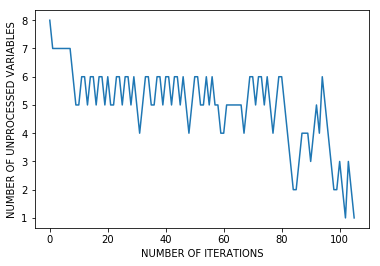

In [5]:
print("Number of iterations:", mfa_h["iterations"])
plt.plot(mfa_h["processed"])
plt.xlabel("NUMBER OF ITERATIONS")
plt.ylabel("NUMBER OF UNPROCESSED VARIABLES")
plt.show()

In [6]:
# Test LBP
more_factors = marginalize_multivariate_factors(my_factors)
temp_factors = copy.deepcopy(my_factors) + more_factors
lbp_factors = discretize_factors(temp_factors)

lbp = LoopyBeliefPropagation(lbp_factors)
lbp_h = lbp.loopy_belief_propagation(lambd=0.1, num_iterations=500)

Loopy BP has converged.


In [7]:
for x,cb in lbp.cluster_beliefs.items():
    print(x)
    print(cb.normalize(inplace=False))

('F', 'C', 'D')
╒═════╤═════╤═════╤══════════════╕
│ F   │ C   │ D   │   phi(F,C,D) │
╞═════╪═════╪═════╪══════════════╡
│ F_0 │ C_0 │ D_0 │       0.0905 │
├─────┼─────┼─────┼──────────────┤
│ F_0 │ C_0 │ D_1 │       0.3320 │
├─────┼─────┼─────┼──────────────┤
│ F_0 │ C_1 │ D_0 │       0.0134 │
├─────┼─────┼─────┼──────────────┤
│ F_0 │ C_1 │ D_1 │       0.1811 │
├─────┼─────┼─────┼──────────────┤
│ F_1 │ C_0 │ D_0 │       0.0929 │
├─────┼─────┼─────┼──────────────┤
│ F_1 │ C_0 │ D_1 │       0.2281 │
├─────┼─────┼─────┼──────────────┤
│ F_1 │ C_1 │ D_0 │       0.0451 │
├─────┼─────┼─────┼──────────────┤
│ F_1 │ C_1 │ D_1 │       0.0169 │
╘═════╧═════╧═════╧══════════════╛
B
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.2506 │
├─────┼──────────┤
│ B_1 │   0.2422 │
├─────┼──────────┤
│ B_2 │   0.2354 │
├─────┼──────────┤
│ B_3 │   0.2717 │
╘═════╧══════════╛
G
╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.4190 │
├─────┼──────────┤
│ G_1 │   0

In [8]:
for _,sb in lbp.sepset_beliefs.items():
    print(sb.normalize(inplace=False))

╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.4127 │
├─────┼──────────┤
│ E_1 │   0.3433 │
├─────┼──────────┤
│ E_2 │   0.2440 │
╘═════╧══════════╛
╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.6170 │
├─────┼──────────┤
│ F_1 │   0.3830 │
╘═════╧══════════╛
╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.6170 │
├─────┼──────────┤
│ F_1 │   0.3830 │
╘═════╧══════════╛
╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.4190 │
├─────┼──────────┤
│ G_1 │   0.1255 │
├─────┼──────────┤
│ G_2 │   0.1591 │
├─────┼──────────┤
│ G_3 │   0.2963 │
╘═════╧══════════╛
╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.7436 │
├─────┼──────────┤
│ C_1 │   0.2564 │
╘═════╧══════════╛
╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.4127 │
├─────┼──────────┤
│ E_1 │   0.3433 │
├─────┼──────────┤
│ E_2 │   0.2440 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪═════

Number of iterations: 386


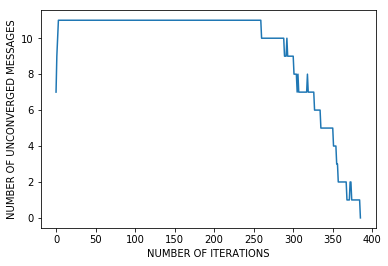

In [9]:
print("Number of iterations:", lbp_h["iterations"])
plt.plot(lbp_h["convergence"])
plt.xlabel("NUMBER OF ITERATIONS")
plt.ylabel("NUMBER OF UNCONVERGED MESSAGES")
plt.show()

In [10]:
# Exact inference
bp = BeliefPropagation(network)
bp.calibrate()
vars_to_query = set()
for f in my_factors:
    vars_query = f.scope()
    vars_to_query = vars_to_query.union(vars_query)
for v in vars_to_query:
    f = bp.query([v])
    print(f[v])

╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.4646 │
├─────┼──────────┤
│ E_1 │   0.2553 │
├─────┼──────────┤
│ E_2 │   0.2802 │
╘═════╧══════════╛
╒═════╤══════════╕
│ B   │   phi(B) │
╞═════╪══════════╡
│ B_0 │   0.2500 │
├─────┼──────────┤
│ B_1 │   0.2500 │
├─────┼──────────┤
│ B_2 │   0.2500 │
├─────┼──────────┤
│ B_3 │   0.2500 │
╘═════╧══════════╛
╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.5750 │
├─────┼──────────┤
│ F_1 │   0.4250 │
╘═════╧══════════╛
╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.2500 │
├─────┼──────────┤
│ D_1 │   0.7500 │
╘═════╧══════════╛
╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.2896 │
├─────┼──────────┤
│ G_1 │   0.1845 │
├─────┼──────────┤
│ G_2 │   0.2371 │
├─────┼──────────┤
│ G_3 │   0.2888 │
╘═════╧══════════╛
╒═════╤══════════╕
│ A   │   phi(A) │
╞═════╪══════════╡
│ A_0 │   0.0100 │
├─────┼──────────┤
│ A_1 │   0.9000 │
├─────┼──────────┤
│ A_2 │   0.

In [11]:
for _, val in bp.get_clique_beliefs().items():
    print(val.normalize(inplace=False))

╒═════╤═════╤═════╤══════════════╕
│ A   │ E   │ B   │   phi(A,E,B) │
╞═════╪═════╪═════╪══════════════╡
│ A_0 │ E_0 │ B_0 │       0.0002 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_0 │ B_1 │       0.0020 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_0 │ B_2 │       0.0006 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_0 │ B_3 │       0.0000 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_1 │ B_0 │       0.0005 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_1 │ B_1 │       0.0001 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_1 │ B_2 │       0.0006 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_1 │ B_3 │       0.0020 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_2 │ B_0 │       0.0017 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_2 │ B_1 │       0.0004 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_2 │ B_2 │       0.0012 │
├─────┼─────┼─────┼──────────────┤
│ A_0 │ E_2 │ B_3 │       0.0005 │
├─────┼─────┼─────┼──────────────┤
│ A_1 │ E_0 │ B_0 │       0.0562 │
├─────┼─────┼─────┼─

In [12]:
for _, val in bp.get_sepset_beliefs().items():
    print(val.normalize(inplace=False))

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.2896 │
├─────┼──────────┤
│ G_1 │   0.1845 │
├─────┼──────────┤
│ G_2 │   0.2371 │
├─────┼──────────┤
│ G_3 │   0.2888 │
╘═════╧══════════╛
╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.5750 │
├─────┼──────────┤
│ F_1 │   0.4250 │
╘═════╧══════════╛
╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.4646 │
├─────┼──────────┤
│ E_1 │   0.2552 │
├─────┼──────────┤
│ E_2 │   0.2802 │
╘═════╧══════════╛


### P(E|A=0,B=0)

In [14]:
print(bp.query(['E'], evidence={'A':0, 'B':0})['E'])

╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.1000 │
├─────┼──────────┤
│ E_1 │   0.2000 │
├─────┼──────────┤
│ E_2 │   0.7000 │
╘═════╧══════════╛


In [20]:
e_evid = lbp.cluster_beliefs[('E', 'A', 'B')].normalize(inplace=False)
e_evid = e_evid.reduce([('A',0),('B',0)], inplace=False).normalize(inplace=False)
print(e_evid)

╒═════╤══════════╕
│ E   │   phi(E) │
╞═════╪══════════╡
│ E_0 │   0.0918 │
├─────┼──────────┤
│ E_1 │   0.2780 │
├─────┼──────────┤
│ E_2 │   0.6301 │
╘═════╧══════════╛


In [122]:
query_all = (mfa.Q['H'] * mfa.Q['G'] * mfa.Q['A'] *
            mfa.Q['B'] * mfa.Q['C'] * mfa.Q['D'] *
            mfa.Q['E'] * mfa.Q['F']).normalize(inplace=False)
e_evid = query_all.reduce([('A',0),('B',0)], inplace=False).normalize(inplace=False)
print(e_evid)

╒═════╤═════╤═════╤═════╤═════╤═════╤════════════════════╕
│ H   │ G   │ C   │ D   │ E   │ F   │   phi(H,G,C,D,E,F) │
╞═════╪═════╪═════╪═════╪═════╪═════╪════════════════════╡
│ H_0 │ G_0 │ C_0 │ D_0 │ E_0 │ F_0 │             0.0047 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ C_0 │ D_0 │ E_0 │ F_1 │             0.0041 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ C_0 │ D_0 │ E_1 │ F_0 │             0.0045 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ C_0 │ D_0 │ E_1 │ F_1 │             0.0040 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ C_0 │ D_0 │ E_2 │ F_0 │             0.0043 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ C_0 │ D_0 │ E_2 │ F_1 │             0.0038 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ C_0 │ D_1 │ E_0 │ F_0 │             0.0079 │
├─────┼─────┼─────┼─────┼─────┼─────┼───────────────────

### P(F|C=0,D=1)

In [35]:
print(bp.query(['F'], evidence={'C':0, 'D':1})['F'])

╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.5500 │
├─────┼──────────┤
│ F_1 │   0.4500 │
╘═════╧══════════╛


In [37]:
f_evid = lbp.cluster_beliefs[('F', 'C', 'D')].normalize(inplace=False)
f_evid = f_evid.reduce([('C',0),('D',1)], inplace=False).normalize(inplace=False)
print(f_evid)

╒═════╤══════════╕
│ F   │   phi(F) │
╞═════╪══════════╡
│ F_0 │   0.5927 │
├─────┼──────────┤
│ F_1 │   0.4073 │
╘═════╧══════════╛


In [123]:
query_all = (mfa.Q['H'] * mfa.Q['G'] * mfa.Q['A'] *
            mfa.Q['B'] * mfa.Q['C'] * mfa.Q['D'] *
            mfa.Q['E'] * mfa.Q['F']).normalize(inplace=False)
f_evid = query_all.reduce([('C',0),('D',1)], inplace=False).normalize(inplace=False)
print(f_evid)

╒═════╤═════╤═════╤═════╤═════╤═════╤════════════════════╕
│ H   │ G   │ A   │ B   │ E   │ F   │   phi(H,G,A,B,E,F) │
╞═════╪═════╪═════╪═════╪═════╪═════╪════════════════════╡
│ H_0 │ G_0 │ A_0 │ B_0 │ E_0 │ F_0 │             0.0011 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ E_0 │ F_1 │             0.0010 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ E_1 │ F_0 │             0.0011 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ E_1 │ F_1 │             0.0009 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ E_2 │ F_0 │             0.0010 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ E_2 │ F_1 │             0.0009 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_1 │ E_0 │ F_0 │             0.0011 │
├─────┼─────┼─────┼─────┼─────┼─────┼───────────────────

### P(G|E=2,F=0)

In [41]:
print(bp.query(['G'], evidence={'E':2, 'F':0})['G'])

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.2500 │
├─────┼──────────┤
│ G_1 │   0.2000 │
├─────┼──────────┤
│ G_2 │   0.1500 │
├─────┼──────────┤
│ G_3 │   0.4000 │
╘═════╧══════════╛


In [44]:
g_evid = lbp.cluster_beliefs[('G', 'E', 'F')].normalize(inplace=False)
g_evid = g_evid.reduce([('E',2),('F',0)], inplace=False).normalize(inplace=False)
print(g_evid)

╒═════╤══════════╕
│ G   │   phi(G) │
╞═════╪══════════╡
│ G_0 │   0.3489 │
├─────┼──────────┤
│ G_1 │   0.1376 │
├─────┼──────────┤
│ G_2 │   0.1009 │
├─────┼──────────┤
│ G_3 │   0.4126 │
╘═════╧══════════╛


In [124]:
query_all = (mfa.Q['H'] * mfa.Q['G'] * mfa.Q['A'] *
            mfa.Q['B'] * mfa.Q['C'] * mfa.Q['D'] *
            mfa.Q['E'] * mfa.Q['F']).normalize(inplace=False)
g_evid = query_all.reduce([('E',2),('F',0)], inplace=False).normalize(inplace=False)
print(g_evid)

╒═════╤═════╤═════╤═════╤═════╤═════╤════════════════════╕
│ H   │ G   │ A   │ B   │ C   │ D   │   phi(H,G,A,B,C,D) │
╞═════╪═════╪═════╪═════╪═════╪═════╪════════════════════╡
│ H_0 │ G_0 │ A_0 │ B_0 │ C_0 │ D_0 │             0.0014 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ C_0 │ D_1 │             0.0023 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ C_1 │ D_0 │             0.0008 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_0 │ C_1 │ D_1 │             0.0014 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_1 │ C_0 │ D_0 │             0.0014 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_1 │ C_0 │ D_1 │             0.0024 │
├─────┼─────┼─────┼─────┼─────┼─────┼────────────────────┤
│ H_0 │ G_0 │ A_0 │ B_1 │ C_1 │ D_0 │             0.0009 │
├─────┼─────┼─────┼─────┼─────┼─────┼───────────────────

### P(H|G=some_g)

In [ ]:
some_g = 2

In [85]:
print(bp.query(['H'], evidence={'G':some_g})['H'])

╒═════╤══════════╕
│ H   │   phi(H) │
╞═════╪══════════╡
│ H_0 │   0.5000 │
├─────┼──────────┤
│ H_1 │   0.5000 │
╘═════╧══════════╛


In [82]:
h_evid = lbp.cluster_beliefs[('H', 'G')].normalize(inplace=False)
h_evid = h_evid.reduce([('G',some_g)],inplace=False).normalize(inplace=False)
print(h_evid)

╒═════╤══════════╕
│ H   │   phi(H) │
╞═════╪══════════╡
│ H_0 │   0.2850 │
├─────┼──────────┤
│ H_1 │   0.7150 │
╘═════╧══════════╛


In [120]:
query_all = (mfa.Q['H'] * mfa.Q['G'] * mfa.Q['A'] *
            mfa.Q['B'] * mfa.Q['C'] * mfa.Q['D'] *
            mfa.Q['E'] * mfa.Q['F']).normalize(inplace=False)
h_evid = query_hg.reduce([('G',some_g)], inplace=False).normalize(inplace=False)
print(h_evid)

╒═════╤═════╤═════╤═════╤═════╤═════╤═════╤══════════════════════╕
│ H   │ A   │ B   │ C   │ D   │ E   │ F   │   phi(H,A,B,C,D,E,F) │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪══════════════════════╡
│ H_0 │ A_0 │ B_0 │ C_0 │ D_0 │ E_0 │ F_0 │               0.0009 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼──────────────────────┤
│ H_0 │ A_0 │ B_0 │ C_0 │ D_0 │ E_0 │ F_1 │               0.0008 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼──────────────────────┤
│ H_0 │ A_0 │ B_0 │ C_0 │ D_0 │ E_1 │ F_0 │               0.0009 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼──────────────────────┤
│ H_0 │ A_0 │ B_0 │ C_0 │ D_0 │ E_1 │ F_1 │               0.0008 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼──────────────────────┤
│ H_0 │ A_0 │ B_0 │ C_0 │ D_0 │ E_2 │ F_0 │               0.0008 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼──────────────────────┤
│ H_0 │ A_0 │ B_0 │ C_0 │ D_0 │ E_2 │ F_1 │               0.0007 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼───────────────────

### P(H|E=0,F=0)

In [104]:
some_e = 0
some_f = 1

In [110]:
print(bp.query(['H'], evidence={'E':some_e, 'F':some_f})['H'])

╒═════╤══════════╕
│ H   │   phi(H) │
╞═════╪══════════╡
│ H_0 │   0.2890 │
├─────┼──────────┤
│ H_1 │   0.7110 │
╘═════╧══════════╛


In [111]:
h_evid = (lbp.cluster_beliefs[('H')] * 
          lbp.cluster_beliefs[('E')] * 
          lbp.cluster_beliefs[('F')])
h_evid = h_evid.reduce([('E',some_e), ('F',some_f)],inplace=False).normalize(inplace=False)
print(h_evid)

╒═════╤══════════╕
│ H   │   phi(H) │
╞═════╪══════════╡
│ H_0 │   0.1173 │
├─────┼──────────┤
│ H_1 │   0.8827 │
╘═════╧══════════╛


In [112]:
print(lbp.cluster_beliefs[('H')].normalize(inplace=False))

╒═════╤══════════╕
│ H   │   phi(H) │
╞═════╪══════════╡
│ H_0 │   0.1173 │
├─────┼──────────┤
│ H_1 │   0.8827 │
╘═════╧══════════╛
